#  Accessing HEASARC data on the ODR

###  A brief tutorial on how to access <a href="https://heasarc.gsfc.nasa.gov">HEASARC</a> and <a href="https://lambda.gsfc.nasa.gov">LAMBDA</a> data available through the Amazon AWS <a href="https://registry.opendata.aws/">Open Data Registry</a>. 

In [1]:
#  Set up some useful astronomy libraries:
import pyvo as vo, os, astropy
import astropy.coordinates as coord
import matplotlib.pyplot as plt
%matplotlib inline  
from astropy.io import fits
import astropy.coordinates as coord

#  Set up AWS access with the boto3 and associated libraries:  
import boto3
from botocore import UNSIGNED
from botocore.client import Config
s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))

import warnings
# There are a number of relatively unimportant warnings that show up, so for now, suppress them:
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="astropy.units.format.vounit")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

###  A simple HEASARC search for Chandra imaging data

The first step is to find the HEASARC service that you can use to search for Chandra images:

In [2]:
chandra_services = vo.regsearch(servicetype='image',keywords=['chandra heasarc'])
chandra_services.to_table()['ivoid','short_name','res_title']

<Table length=1>
            ivoid             short_name      res_title      
            object              object          object       
----------------------------- ---------- --------------------
ivo://nasa.heasarc/chanmaster    Chandra Chandra Observations

Next, use Astropy to get the coordinates of your favorite source, in this case the Cas A supernova remnant.  Then query the service for matching images.

In [3]:
coords = coord.SkyCoord.from_name("cas a")

im_table = chandra_services[0].search(pos=coords,size=0.1)
im_table.to_table()[0:5]

<Table length=5>
obsid   status           name             ra    ...   SIA_ra  SIA_dec  SIA_instrument
                                        degree  ...                                  
object  object          object         float64  ...  float64  float64      object    
------ -------- --------------------- --------- ... --------- -------- --------------
  1038 archived                 Cas A 350.86604 ... 350.86604 58.81169  CHANDRA HRC-S
  1038 archived                 Cas A 350.86604 ... 350.86604 58.81169  CHANDRA HRC-S
  1857 archived                 CAS A 350.86606 ... 350.86606 58.81169  CHANDRA HRC-S
  1857 archived                 CAS A 350.86606 ... 350.86606 58.81169  CHANDRA HRC-S
 26655 archived CXOU J232327.8+584842 350.86667 ... 350.86667 58.81178 CHANDRA ACIS-S

Select an image and fetch its URL: 

In [4]:
url = im_table[0].getdataurl()
print(url)

https://heasarc.gsfc.nasa.gov/FTP/chandra/data/byobsid/8/1038/primary/hrcf01038N005_cntr_img2.fits.gz


Now convert that URL into an S3 bucket address and use boto3 to download the object to a local file:

In [5]:
key_name = url.replace("https://heasarc.gsfc.nasa.gov/FTP/","")
s3_client.download_file("nasa-heasarc", key_name, "chandra_casA.fits")
hdu_list = fits.open("chandra_casA.fits")

Now you're ready to analyze this Cas A Chandra image:

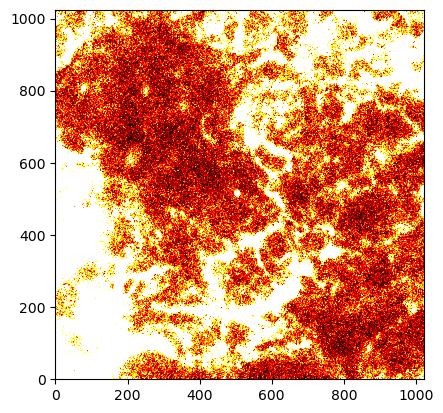

In [6]:
plt.imshow(hdu_list[0].data, cmap='hot', origin='lower',vmax=1)

Note that in astropy>=5.2, you do not have to download the file locally to read it but can give the astropy.io.fits reader the S3 bucket URI directly.  An example is shown below for WMAP.  Obviously you cannot write to the file on the bucket.  

### A simple use case for fetching WMAP data 

The LAMBDA community generally needs full sky datasets, so browsing the products is something that can be done interactively on the <a href="https://lambda.gsfc.nasa.gov/product/">LAMBDA data portal</a>. Once a user has selected, for example, the WMAP DR5 smoothed polarization map for the K band, the portal shows the archive's URL of the dataset.  To find the file on AWS is almost as straightforward as for HEASARC:

In [7]:
url = "https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/smoothed/wmap_band_smth_iqumap_r9_9yr_K_v5.fits"
##  The "map" directory on LAMBDA has been renamed "wmap" on AWS to clarify that it refers to the mission:
s3_uri = url.replace("https://lambda.gsfc.nasa.gov/data/map/","s3://nasa-lambda/wmap/")

With [astropy>=5.2](https://docs.astropy.org/en/stable/io/fits/#working-with-remote-and-cloud-hosted-files), you can read the file directly out of the bucket.  You must also install fsspec and s3fs.  (Astropy will tell you this.) With these libraries, you can open the FITS file and even extract subsets of the data. For this case, we will just visualize the map of one of the columns:

In [8]:
try:
    import fsspec, s3fs
except:
    print("Please install fsspec and s3fs in order to use the cell below.")
    
if tuple(map(int, (astropy.__version__.split(".")))) < tuple(map(int, ("5.2".split(".")))):
    print(f"You have astropoy v{astropy.__version__}. Please update astropy to >= 5.2")

In [9]:
hdul = fits.open(s3_uri, use_fsspec=True, fsspec_kwargs={"anon": True})

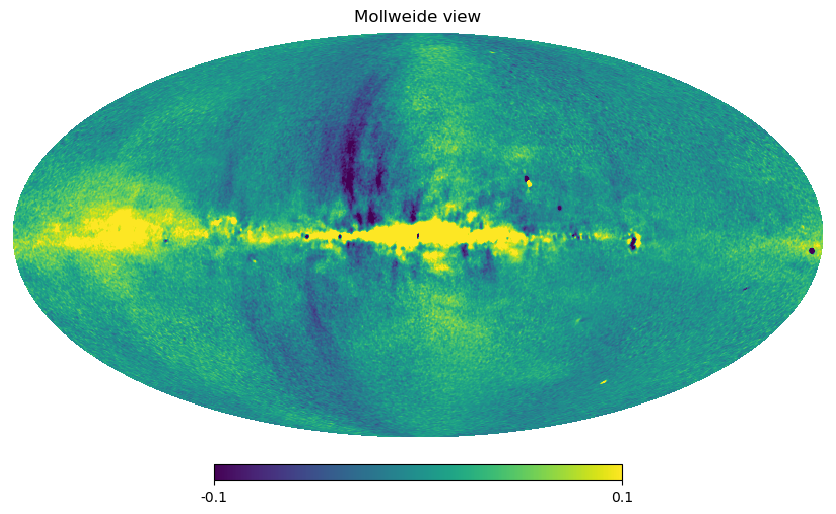

In [10]:
import healpy
healpy.mollview(hdul[1].data['Q_POLARISATION'],nest=True,min=-0.1,max=0.1)